# Churn rate prediction for a telecommunication provider
Milestone: Model Completion

Luwei Wang

Youyu Zhang

In [1]:
# Import common used Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Import dataset 
churn_df = pd.read_csv('train.csv')     # Read dataset 
test = pd.read_csv('test.csv')

In [3]:
churn_df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [4]:
churn_df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [5]:
# Check the shape of dataset
churn_df.shape

(4250, 20)

In [6]:
# Check the basic information of the dataset 
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [7]:
col_name = churn_df.columns.tolist()
print(col_name)

['state', 'account_length', 'area_code', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'churn']


In [8]:
churn_df.isnull().sum()   
# No NA values in the dataframe

# sns.heatmap(churn_df.isnull())

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [9]:
churn_df.area_code.unique()
# Only 3 area_code observed.

array(['area_code_415', 'area_code_408', 'area_code_510'], dtype=object)

In [10]:
print('Maximum account length is: ', churn_df.account_length.max())
print('Unique account length total number is :', len(churn_df.account_length.unique()))
#np.sort(churn_df.account_length.unique())


Maximum account length is:  243
Unique account length total number is : 215


In [11]:
churn_yes = churn_df.loc[churn_df.churn == 'yes',].shape[0]
churn_no = churn_df.loc[churn_df.churn == 'no',].shape[0]
print('Total churn cases number is :', churn_yes , '. It takes proportion of ', round(churn_yes/churn_df.shape[0]*100),'%.')

Total churn cases number is : 598 . It takes proportion of  14 %.


From the information above, we can see that:
1. This dataset consist of 20 columns. 
2. No Null values observed.

### Data Cleaning

In [12]:
# Adjust format for variable: area_code
for i in range(len(churn_df)):
    churn_df['area_code'][i] =  int(churn_df['area_code'][i][-3:])

churn_df.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [13]:
'''
churn_df['result'] = 0
churn_df.loc[churn_df.churn == 'yes', 'result'] = 1

churn_df = churn_df.drop(['churn'], axis = 1)
churn_df.rename(columns={"result": "churn"})
'''

churn_df.churn = pd.Series(np.where(churn_df.churn.values == 'yes', 1, 0),
          churn_df.index)
churn_df.international_plan = pd.Series(np.where(churn_df.international_plan.values == 'yes', 1, 0),
          churn_df.index)
churn_df.voice_mail_plan = pd.Series(np.where(churn_df.voice_mail_plan.values == 'yes', 1, 0),
          churn_df.index)
churn_df = churn_df.drop(columns = ['state'])
churn_df.head()

,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,121,510,0,1,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0


### Plot and Graphs

Text(0, 0.5, 'Number of Cases')

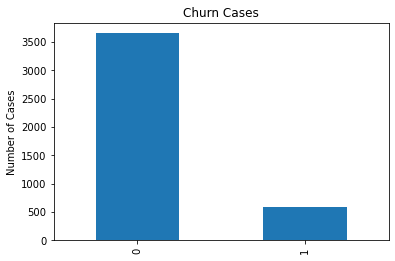

In [14]:
churn_df['churn'].value_counts().plot(kind = 'bar')
plt.title("Churn Cases")
plt.ylabel("Number of Cases")


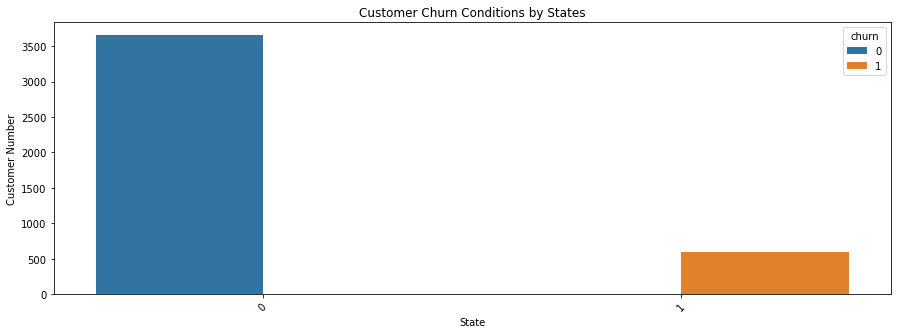

In [15]:
fig, ax=plt.subplots(figsize=(15,5))
sns.countplot(data = churn_df, x='churn', order=churn_df['churn'].value_counts().index, hue='churn')
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Customer Number')
plt.title('Customer Churn Conditions by States')
plt.show()

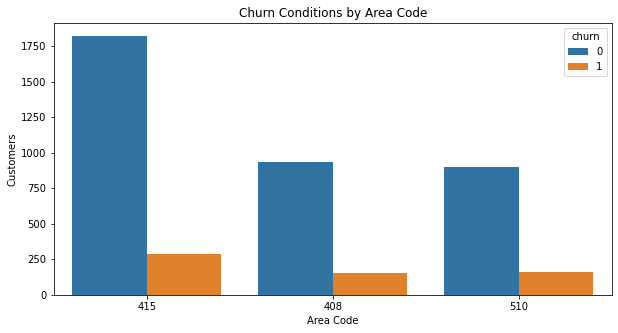

In [16]:
fig2, ax=plt.subplots(figsize=(10,5))
sns.countplot(data = churn_df, x='area_code', order=churn_df['area_code'].value_counts().index, hue='churn')
plt.xlabel('Area Code')
plt.ylabel('Customers')
plt.title('Churn Conditions by Area Code')
plt.show()

Text(0, 0.5, 'number')

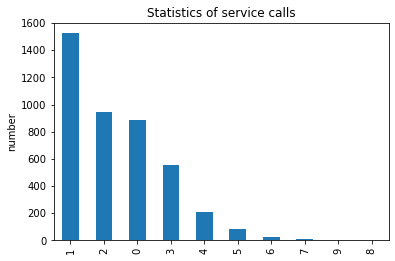

In [17]:
churn_df['number_customer_service_calls'].value_counts().plot(kind = 'bar')
plt.title("Statistics of service calls")
plt.ylabel("number")

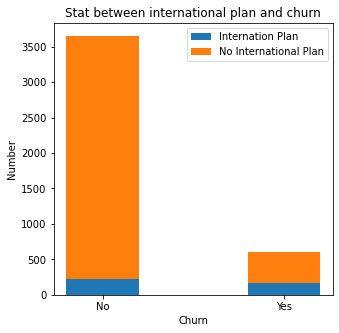

In [18]:
plan_yes = churn_df['churn'][churn_df['international_plan'] == 1].value_counts()
plan_no = churn_df['churn'][churn_df['international_plan'] == 0].value_counts()
plan_df = pd.DataFrame({'international plan':plan_yes, 'no international plan':plan_no})

#plan_df.plot(kind = 'bar', stacked = True)
fig3, ax= plt.subplots(figsize=(5,5))
types = ['No','Yes']
ax.bar(types, plan_yes, 0.4, label = 'Internation Plan')  # 0.4 is the width of the bar
ax.bar(types, plan_no , 0.4, bottom = plan_yes, label = 'No International Plan')
ax.set_title("Stat between international plan and churn")
ax.set_xlabel("Churn")
ax.set_ylabel("Number")
ax.legend()
plt.show()


Text(0, 0.5, 'number')

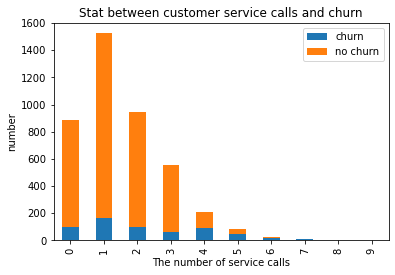

In [19]:
call_0 = churn_df['number_customer_service_calls'][churn_df['churn'] == 0].value_counts()
call_1 = churn_df['number_customer_service_calls'][churn_df['churn'] == 1].value_counts()
service_df = pd.DataFrame({'churn':call_1, 'no churn':call_0})
service_df.plot(kind = 'bar', stacked = True)
plt.title("Stat between customer service calls and churn")
plt.xlabel("The number of service calls")
plt.ylabel("number")

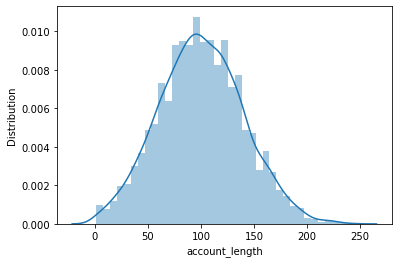

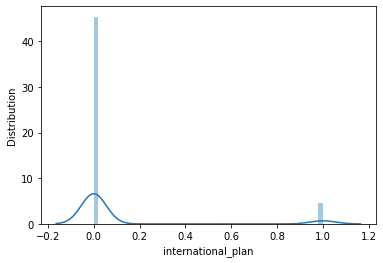

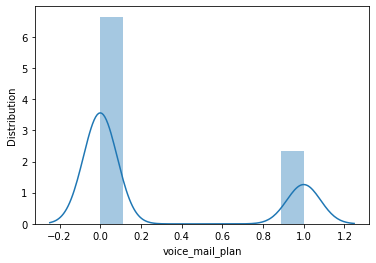

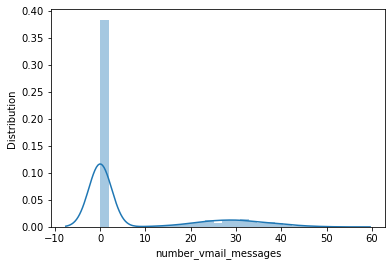

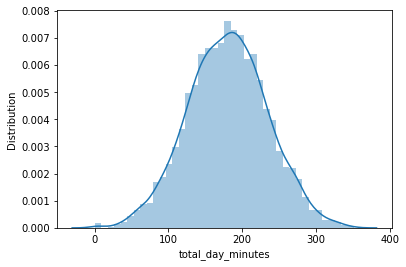

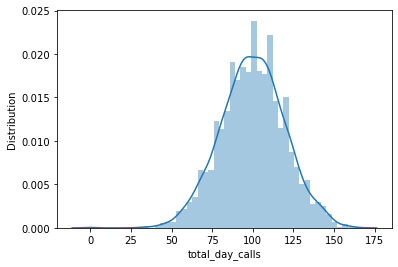

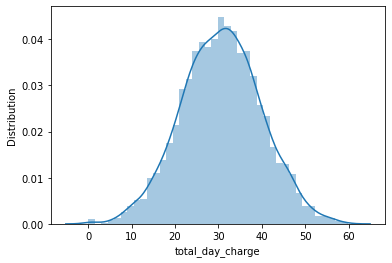

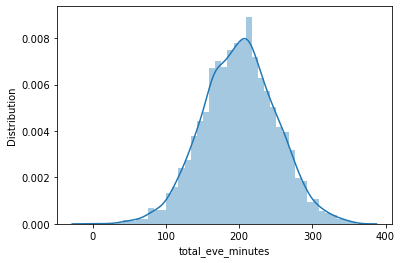

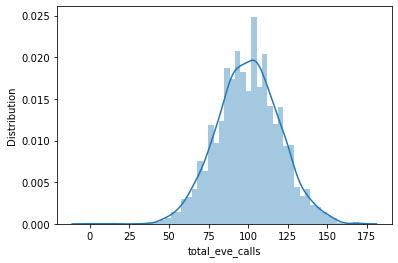

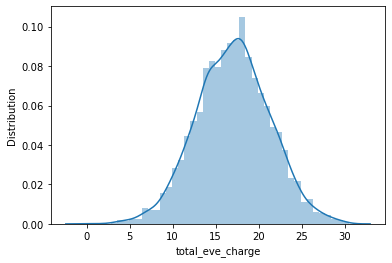

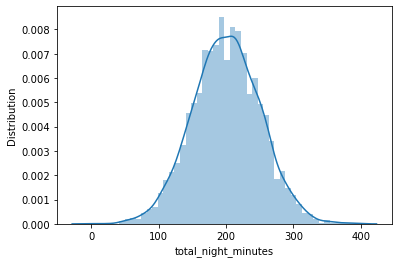

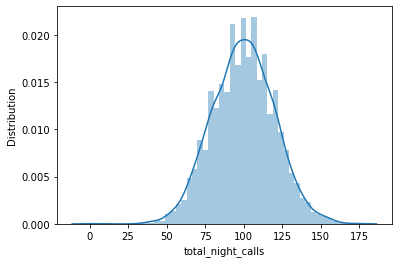

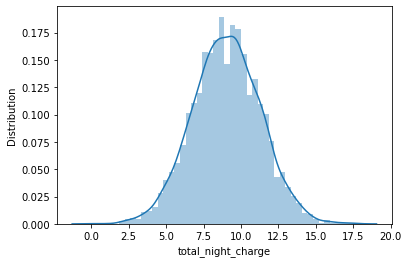

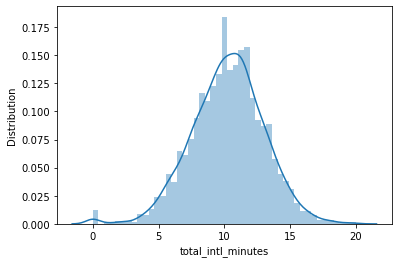

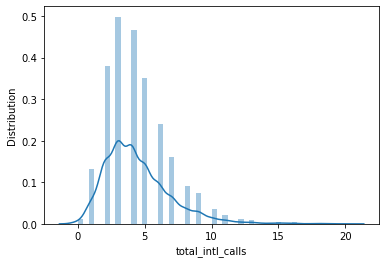

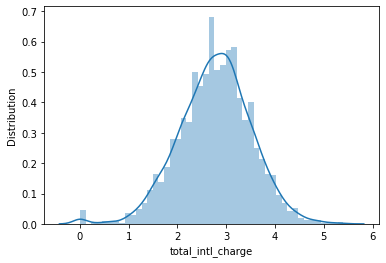

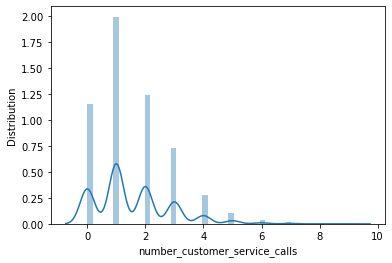

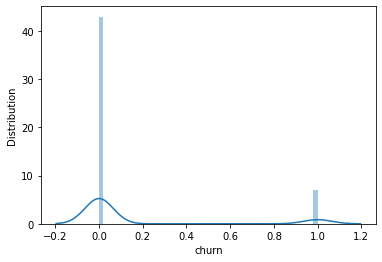

In [20]:
var_numbers = [feature for feature in churn_df.columns if churn_df[feature].dtypes != 'O']

for feature in var_numbers:
    sns.distplot(churn_df[feature])
    plt.xlabel(str(feature))
    plt.ylabel('Distribution')
    plt.show()

# Most number features looks like normal distribution

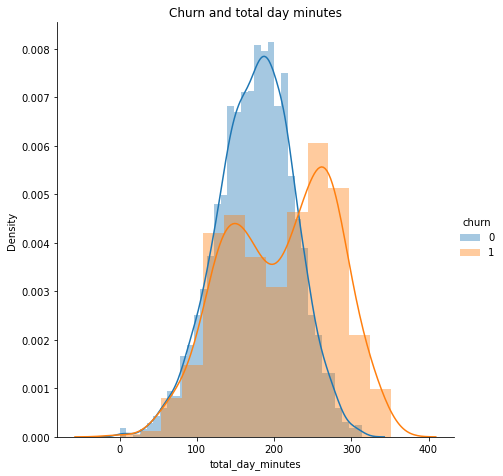

In [21]:
sns.FacetGrid(churn_df, hue='churn',size = 6.5).map(sns.distplot, 'total_day_minutes').add_legend()
plt.title('Churn and total day minutes')
plt.show()

Text(0, 0.5, 'Number of Cases')

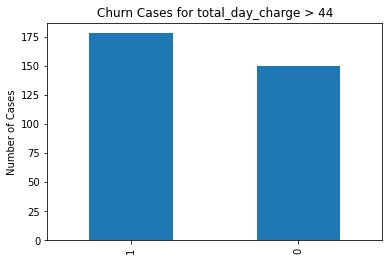

In [22]:
churn30 = churn_df.loc[churn_df['total_day_charge']>44]

churn30['churn'].value_counts().plot(kind = 'bar')
plt.title("Churn Cases for total_day_charge > 44")
plt.ylabel("Number of Cases")

#churn_df.total_day_charge

## Correlation Check
The graph below indicates that **total day charge** and **total day minutes** are 100% positive correlated. Same as **total eve minutes** and **total eve charge**, **total night minutes** and **total night charge**, **total intl minutes** and **total intl charge**. This means the charges are linear relative to minutes of calls, which match the common telecommunication service business model. 

Also, multicollinearity exists, and it can lead to inaccurate prediction later. Decision tree and boosted trees can avoid this inaccuracy. Logistic regression and linear regression will lead to skewed results. 

                               account_length  international_plan  \
account_length                       1.000000            0.027050   
international_plan                   0.027050            1.000000   
voice_mail_plan                      0.001663            0.000714   
number_vmail_messages               -0.006626            0.004808   
total_day_minutes                   -0.001612            0.040059   
total_day_calls                      0.023002            0.009776   
total_day_charge                    -0.001613            0.040061   
total_eve_minutes                   -0.010326            0.023484   
total_eve_calls                      0.005535           -0.003004   
total_eve_charge                    -0.010322            0.023479   
total_night_minutes                 -0.009916           -0.020694   
total_night_calls                   -0.001846            0.007153   
total_night_charge                  -0.009942           -0.020694   
total_intl_minutes                

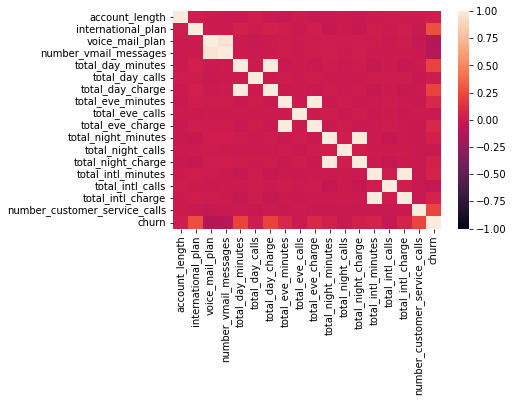

In [23]:
corr = churn_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, vmin=-1, vmax=1)
print(corr)

In [24]:
corr.columns

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls', 'churn'],
      dtype='object')

One of the methods to solve multicollinearity is PCA. Currently we set the explained variance ratio to 90% (0.9)

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Un-standardized PCA
pcs = PCA(n_components = 0.9)  #Expect explain 90% of variance
pcs.fit(churn_df[corr.columns])
pcsSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
                           'Proportion of variance': pcs.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary_df= pcsSummary_df.transpose()
pcsSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary_df.columns) + 1)]
pcsSummary_df.round(4)

,PC1,PC2,PC3,PC4,PC5
Standard deviation,54.8325,50.7229,50.0755,39.6911,20.1571
Proportion of variance,0.2720,0.2328,0.2269,0.1425,0.0368
Cumulative proportion,0.2720,0.5048,0.7317,0.8742,0.9110


In [26]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(), columns=pcsSummary_df.columns, 
                                index=corr.columns)
pcsComponents_df   

,PC1,PC2,PC3,PC4,PC5
account_length,0.002131,-0.001157,-0.030728,0.999394,-0.005492
international_plan,-0.000195,0.000203,0.000009,0.000200,-0.000095
voice_mail_plan,0.000003,-0.000038,0.000200,0.000019,-0.000192
number_vmail_messages,-0.000594,-0.001396,0.006045,-0.002244,-0.001067
total_day_minutes,-0.980267,0.104101,0.011427,0.002546,-0.002973
total_day_calls,-0.000075,0.002150,0.003343,0.015549,0.186864
total_day_charge,-0.166645,0.017697,0.001943,0.000432,-0.000504
total_eve_minutes,0.083220,0.706606,0.697180,0.022018,0.003563
total_eve_calls,-0.002600,-0.001369,0.003839,0.003954,0.449692
total_eve_charge,0.007075,0.060062,0.059260,0.001872,0.000305


In [27]:
# Standardized PCA
norm = StandardScaler()
norm.fit(churn_df[corr.columns])
pcastan = PCA(n_components = 0.9)
pcastan.fit(norm.transform(churn_df[corr.columns]))

pcaSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcastan.explained_variance_),
                           'Proportion of variance': pcastan.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pcastan.explained_variance_ratio_)})
pcaSummary_df= pcaSummary_df.transpose()
pcaSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(pcaSummary_df.columns) + 1)]
pcaSummary_df.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Standard deviation,1.4578,1.4279,1.4192,1.4156,1.3913,1.1123,1.0244,1.0091,0.9972,0.9907,0.9894
Proportion of variance,0.1180,0.1133,0.1119,0.1113,0.1075,0.0687,0.0583,0.0566,0.0552,0.0545,0.0544
Cumulative proportion,0.1180,0.2313,0.3432,0.4545,0.5620,0.6307,0.6890,0.7455,0.8008,0.8553,0.9097


In [28]:
pcaComponents_df = pd.DataFrame(pcastan.components_.transpose(), columns=pcaSummary_df.columns, 
                                index=corr.columns)
pcaComponents_df   

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
account_length,0.003497,0.005656,0.002079,-0.019665,0.008307,0.107421,0.535715,-0.148290,-0.014611,-0.025987,-0.366173
international_plan,0.107808,0.065182,-0.062808,-0.018880,0.021528,0.521165,0.368406,0.247634,0.009807,-0.045929,0.531005
voice_mail_plan,-0.174676,-0.211850,-0.180205,0.348468,0.507639,0.096834,-0.005455,-0.003525,-0.007170,0.000011,-0.013194
number_vmail_messages,-0.170332,-0.211550,-0.179333,0.348687,0.507883,0.105937,-0.004819,-0.009513,-0.000477,0.009937,-0.009890
total_day_minutes,0.621094,0.006757,-0.026766,-0.003442,0.255396,-0.189821,-0.016551,-0.007906,-0.004283,-0.004073,-0.030488
total_day_calls,0.006363,0.011189,-0.014889,-0.005838,-0.011850,0.002402,0.504634,-0.201364,-0.464961,-0.180490,-0.331109
total_day_charge,0.621095,0.006756,-0.026763,-0.003440,0.255392,-0.189828,-0.016549,-0.007907,-0.004290,-0.004075,-0.030483
total_eve_minutes,0.022675,0.457114,-0.284804,0.415222,-0.168514,-0.074382,-0.017231,-0.014929,-0.008924,0.003226,-0.015996
total_eve_calls,0.008373,-0.006824,0.009101,0.017572,-0.004033,-0.010022,0.056474,-0.647365,0.469346,-0.546772,0.230896
total_eve_charge,0.022666,0.457113,-0.284803,0.415225,-0.168510,-0.074384,-0.017225,-0.014942,-0.008918,0.003216,-0.015991


### Feature Selection with VIF (Variance Inflation Factor) Check
This process will determine if multicollinearity exists and remove the redundent features. 

The criterion is VIF > 0.8. That means we will drop one of the variables from variable pairs with VIF > 0.8. 

In [29]:
from sklearn.metrics import r2_score

vif = pd.DataFrame(columns = ['var1', 'var2', 'R2'])
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if i != j:
            r2value = r2_score(churn_df[corr.columns[i]],churn_df[corr.columns[j]])
            vifvalue = 1/(1-r2value)
            if vifvalue >= 0.8:
                vif = vif.append({'var1' : corr.columns[i], 'var2' : corr.columns[j], 'R2' : vifvalue}, 
                ignore_index = True)

vif

,var1,var2,R2
0,account_length,total_day_calls,0.814926
1,account_length,total_eve_calls,0.802601
2,number_vmail_messages,voice_mail_plan,0.806809
3,number_vmail_messages,total_night_charge,0.968067
4,number_vmail_messages,total_intl_minutes,0.927499
5,number_vmail_messages,total_intl_calls,0.919060
6,number_vmail_messages,total_intl_charge,0.882302
7,number_vmail_messages,number_customer_service_calls,0.821884


In [30]:
#Delete features listed in vif.var1
df = churn_df
df = df.drop(vif.var1.unique(),axis = 1)

df

,area_code,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,415,0,1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
1,415,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
2,408,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
3,415,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
4,510,0,1,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,415,0,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,0
4246,408,0,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,0
4247,408,0,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,0
4248,408,0,1,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,0


### Decision Tree


In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Split dataset into train and test
df2 = df.drop(['churn'], axis = 1)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df2,df.churn,test_size=0.2)

# Add model and predict
score = []
acc = []
cross = []
for i in range(20):
    decision_tree = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=i+1)
    decision_tree.fit(Xtrain, Ytrain)
    Y_pred = decision_tree.predict(Xtest)
    
    acc_decision_tree = round(decision_tree.score(Xtest,Y_pred,)*100, 2)
    acc.append(acc_decision_tree)

    result = pd.DataFrame()
    result['Test'] = Ytest
    result['Prediction'] = Y_pred
    result['correct'] = pd.Series(np.where(result.Test.values == result.Prediction.values, 1, 0),
            result.index)
    modelscore = round(result.correct.sum()/result.shape[0],2)
    score.append(modelscore)

    cross_value = cross_val_score(decision_tree, Xtrain, Ytrain, cv = 5)
    cross.append(cross_value)

cross_validation = pd.DataFrame(cross)
cross_validation['avg'] = cross_validation.mean(axis = 1)

print(score)
print(cross_validation)

# Thus max_depth = 5 would be a better choice.


[0.88, 0.89, 0.91, 0.93, 0.94, 0.95, 0.96, 0.96, 0.96, 0.96, 0.94, 0.93, 0.94, 0.94, 0.94, 0.93, 0.93, 0.92, 0.92, 0.92]
           0         1         2         3         4       avg
0   0.866176  0.851471  0.875000  0.879412  0.867647  0.867941
1   0.867647  0.866176  0.880882  0.892647  0.879412  0.877353
2   0.895588  0.898529  0.895588  0.927941  0.908824  0.905294
3   0.911765  0.923529  0.916176  0.939706  0.926471  0.923529
4   0.917647  0.942647  0.929412  0.950000  0.936765  0.935294
5   0.926471  0.951471  0.935294  0.947059  0.936765  0.939412
6   0.932353  0.951471  0.942647  0.952941  0.941176  0.944118
7   0.925000  0.950000  0.932353  0.947059  0.938235  0.938529
8   0.927941  0.952941  0.927941  0.950000  0.941176  0.940000
9   0.929412  0.951471  0.923529  0.945588  0.939706  0.937941
10  0.911765  0.942647  0.922059  0.945588  0.936765  0.931765
11  0.927941  0.944118  0.923529  0.944118  0.929412  0.933824
12  0.914706  0.945588  0.914706  0.933824  0.923529  0.9264

Text(0, 0.5, 'cross_validation_score')

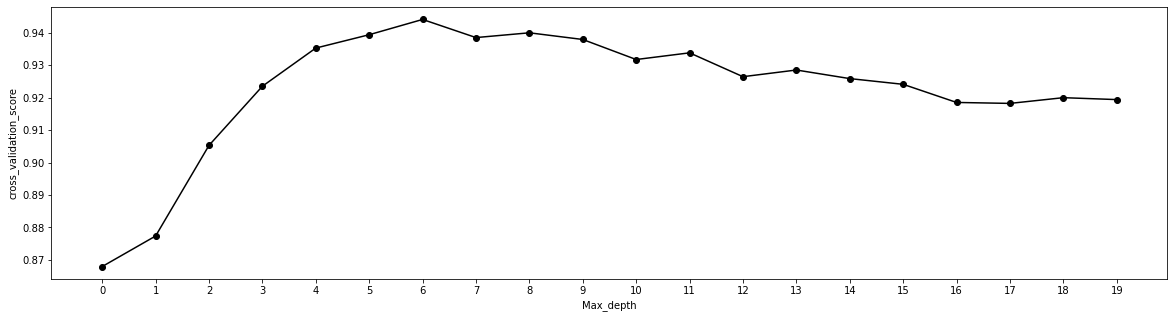

In [32]:
rs = np.array(cross_validation['avg'])
plt.figure(figsize = (20,5))
plt.plot(range(20),rs,'o-',c = 'black', label = 'Decision_tree')
x=np.arange(0,20,1)
plt.xticks(x)
plt.xlabel('Max_depth')
plt.ylabel('cross_validation_score')

### Use XGBoost Classifier as a Method

In [33]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
# Split dataset into train and test
df2 = churn_df.drop(['churn'], axis = 1)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df2,df.churn,test_size=0.2)
Xtest['area_code'] = lbl.fit_transform(Xtest['area_code'].astype(str))
Xtrain['area_code'] = lbl.fit_transform(Xtrain['area_code'].astype(str))

# Add model and predict
score_xgb = []
acc = []
cross_xgb = []
for i in range(20):
    xgb_model = xgb.XGBClassifier(eta=0.3, max_depth=i+1, colsample_bytree=0.5, scale_pos_weight=1.1, booster='gbtree', random_state= 42)
    xgb_pred = xgb_model.fit(Xtrain._get_numeric_data(), np.ravel(Ytrain, order='C')).predict(Xtest._get_numeric_data())    
    
    acc_xgb = round(xgb_model.score(Xtest,xgb_pred,)*100, 2)
    acc.append(acc_xgb)

    result = pd.DataFrame()
    result['Test'] = Ytest
    result['Prediction'] = xgb_pred
    result['correct'] = pd.Series(np.where(result.Test.values == result.Prediction.values, 1, 0),
            result.index)
    modelscore = round(result.correct.sum()/result.shape[0],2)
    score_xgb.append(modelscore)

    cross_value = cross_val_score(xgb_model, Xtrain, Ytrain, cv = 5)
    cross_xgb.append(cross_value)

cross_validation_xgb = pd.DataFrame(cross_xgb)
cross_validation_xgb['avg'] = cross_validation_xgb.mean(axis = 1)

print(score_xgb)
print(cross_validation_xgb)
# Thus max_depth = 4 would be a better choice.
# Adjusting eta doesn't make big difference.

[12:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:20:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0, 0.5, 'cross_validation_score_xgb')

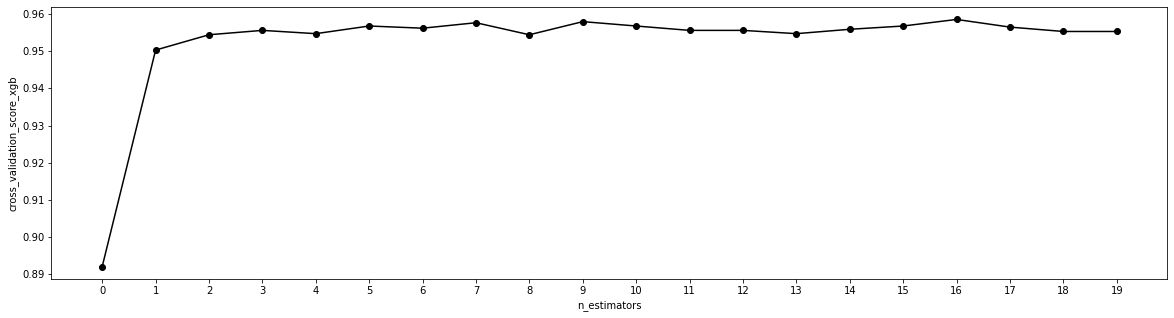

In [34]:
rs = np.array(cross_validation_xgb['avg'])
plt.figure(figsize = (20,5))
plt.plot(range(20),rs,'o-',c = 'black', label = 'XGBoost')
x=np.arange(0,20,1)
plt.xticks(x)
plt.xlabel('n_estimators')
plt.ylabel('cross_validation_score_xgb')

### Neuron Network Trial

In [35]:
from sklearn.neural_network import MLPClassifier

# Add model and predict
score_mlp = []
acc_mlp = []
cross_mlp = []
for i in range(5):
        mlp = MLPClassifier(hidden_layer_sizes=(2,2,2,3,i+1), activation='identity', solver='lbfgs', random_state=42)
        mlp.fit(Xtrain, Ytrain)
        Y_pred = mlp.predict(Xtest)

        acc = round(mlp.score(Xtest,Y_pred,)*100, 2)
        acc_mlp.append(acc)

        result = pd.DataFrame()
        result['Test'] = Ytest
        result['Prediction'] = Y_pred
        result['correct'] = pd.Series(np.where(result.Test.values == result.Prediction.values, 1, 0),
                result.index)
        modelscore = round(result.correct.sum()/result.shape[0],2)
        score_mlp.append(modelscore)

        cross_value = cross_val_score(mlp, Xtrain, Ytrain, cv = 5)
        cross_mlp.append(cross_value)

cross_validation_mlp = pd.DataFrame(cross_mlp)
cross_validation_mlp['avg'] = cross_validation_mlp.mean(axis = 1)

print(score_mlp)
print(cross_validation_mlp)


[0.85, 0.85, 0.85, 0.86, 0.82]
          0         1         2         3         4       avg
0  0.867647  0.866176  0.870588  0.861765  0.861765  0.865588
1  0.861765  0.863235  0.864706  0.861765  0.861765  0.862647
2  0.861765  0.866176  0.842647  0.863235  0.844118  0.855588
3  0.866176  0.864706  0.864706  0.861765  0.861765  0.863824
4  0.836765  0.842647  0.838235  0.826471  0.839706  0.836765


In [36]:
from sklearn.neighbors import KNeighborsClassifier

score_knn = []
acc_knn = []
cross_knn = []

for i in range(10):
        neigh = KNeighborsClassifier(n_neighbors=i+1)
        neigh.fit(Xtrain, Ytrain)
        Y_pred = neigh.predict(Xtest)

        result = pd.DataFrame()
        result['Test'] = Ytest
        result['Prediction'] = Y_pred
        result['correct'] = pd.Series(np.where(result.Test.values == result.Prediction.values, 1, 0),
                result.index)
        modelscore = round(result.correct.sum()/result.shape[0],2)
        score_knn.append(modelscore)

        cross_value = cross_val_score(neigh, Xtrain, Ytrain, cv = 5)
        cross_knn.append(cross_value)

cross_validation_knn = pd.DataFrame(cross_knn)
cross_validation_knn['avg'] = cross_validation_knn.mean(axis = 1)

print(score_knn)
print(cross_validation_knn)

[0.82, 0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.88, 0.89, 0.88]
          0         1         2         3         4       avg
0  0.823529  0.813235  0.833824  0.820588  0.802941  0.818824
1  0.888235  0.877941  0.882353  0.877941  0.870588  0.879412
2  0.888235  0.883824  0.866176  0.872059  0.870588  0.876176
3  0.894118  0.891176  0.891176  0.882353  0.873529  0.886471
4  0.900000  0.889706  0.889706  0.885294  0.875000  0.887941
5  0.900000  0.891176  0.889706  0.888235  0.877941  0.889412
6  0.898529  0.895588  0.888235  0.889706  0.873529  0.889118
7  0.895588  0.889706  0.892647  0.882353  0.873529  0.886765
8  0.901471  0.891176  0.892647  0.879412  0.875000  0.887941
9  0.898529  0.888235  0.889706  0.879412  0.875000  0.886176


#### Prediction
Use the models to predict the test.csv, then upload to Kaggle for test. 

In [37]:
# Adjust format for variable: area_code
test.area_code = lbl.fit_transform(test.area_code.astype(str))

#test.churn = pd.Series(np.where(test.churn.values == 'yes', 1, 0), test.index)
test.international_plan = pd.Series(np.where(test.international_plan.values == 'yes', 1, 0),
          test.index)
test.voice_mail_plan = pd.Series(np.where(test.voice_mail_plan.values == 'yes', 1, 0),
          test.index)
id = test['id']
tests = test.drop(['id','state',], axis = 1)

print(test.shape)
print(test.columns)
print(Xtrain.shape)
print(Xtrain.columns)
print(tests.shape)


(750, 20)
Index(['id', 'state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')
(3400, 18)
Index(['account_length', 'area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls'],
      dtype='object')
(750, 18)


Use Decision Tree for prediction

In [38]:
decision_tree = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=5)
decision_tree.fit(Xtrain, Ytrain)
Y_test = decision_tree.predict(tests)

submit = pd.DataFrame({'id':id, 'churn':Y_test})
submit.churn.replace([0,1],['no','yes'], inplace=True)
submit.head()
submit.to_csv('churn_submit.csv',index=False)

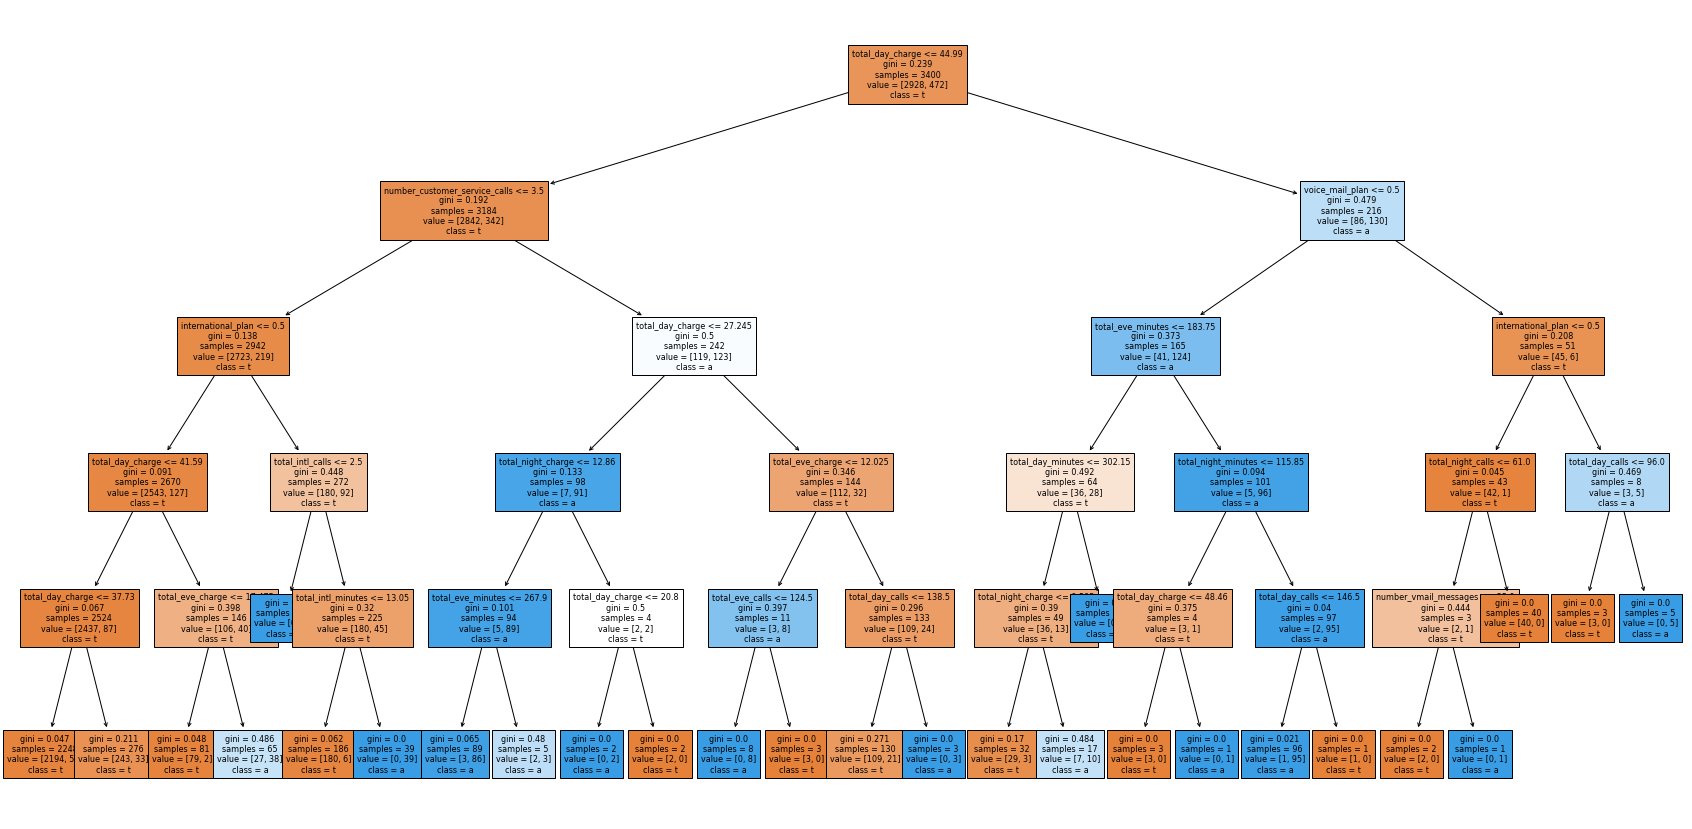

In [39]:
from sklearn import tree
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(30,15))
_ = tree.plot_tree(decision_tree, fontsize=8,
                   feature_names=Xtrain.columns,  
                   class_names='target',
                   filled=True)

Use XGBoost Classifier for prediction


In [40]:
xgboost = xgb.XGBClassifier(eta=0.3, max_depth=4, colsample_bytree=0.5, scale_pos_weight=1.1, booster='gbtree', random_state= 42)
xgboost.fit(Xtrain, Ytrain)
Y_test_xgb = xgboost.predict(tests)

submit_xgb = pd.DataFrame({'id':id, 'churn':Y_test_xgb})
submit_xgb.churn.replace([0,1],['no','yes'], inplace=True)
submit_xgb.to_csv('churn_submitxgboost.csv',index=False)

[12:22:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


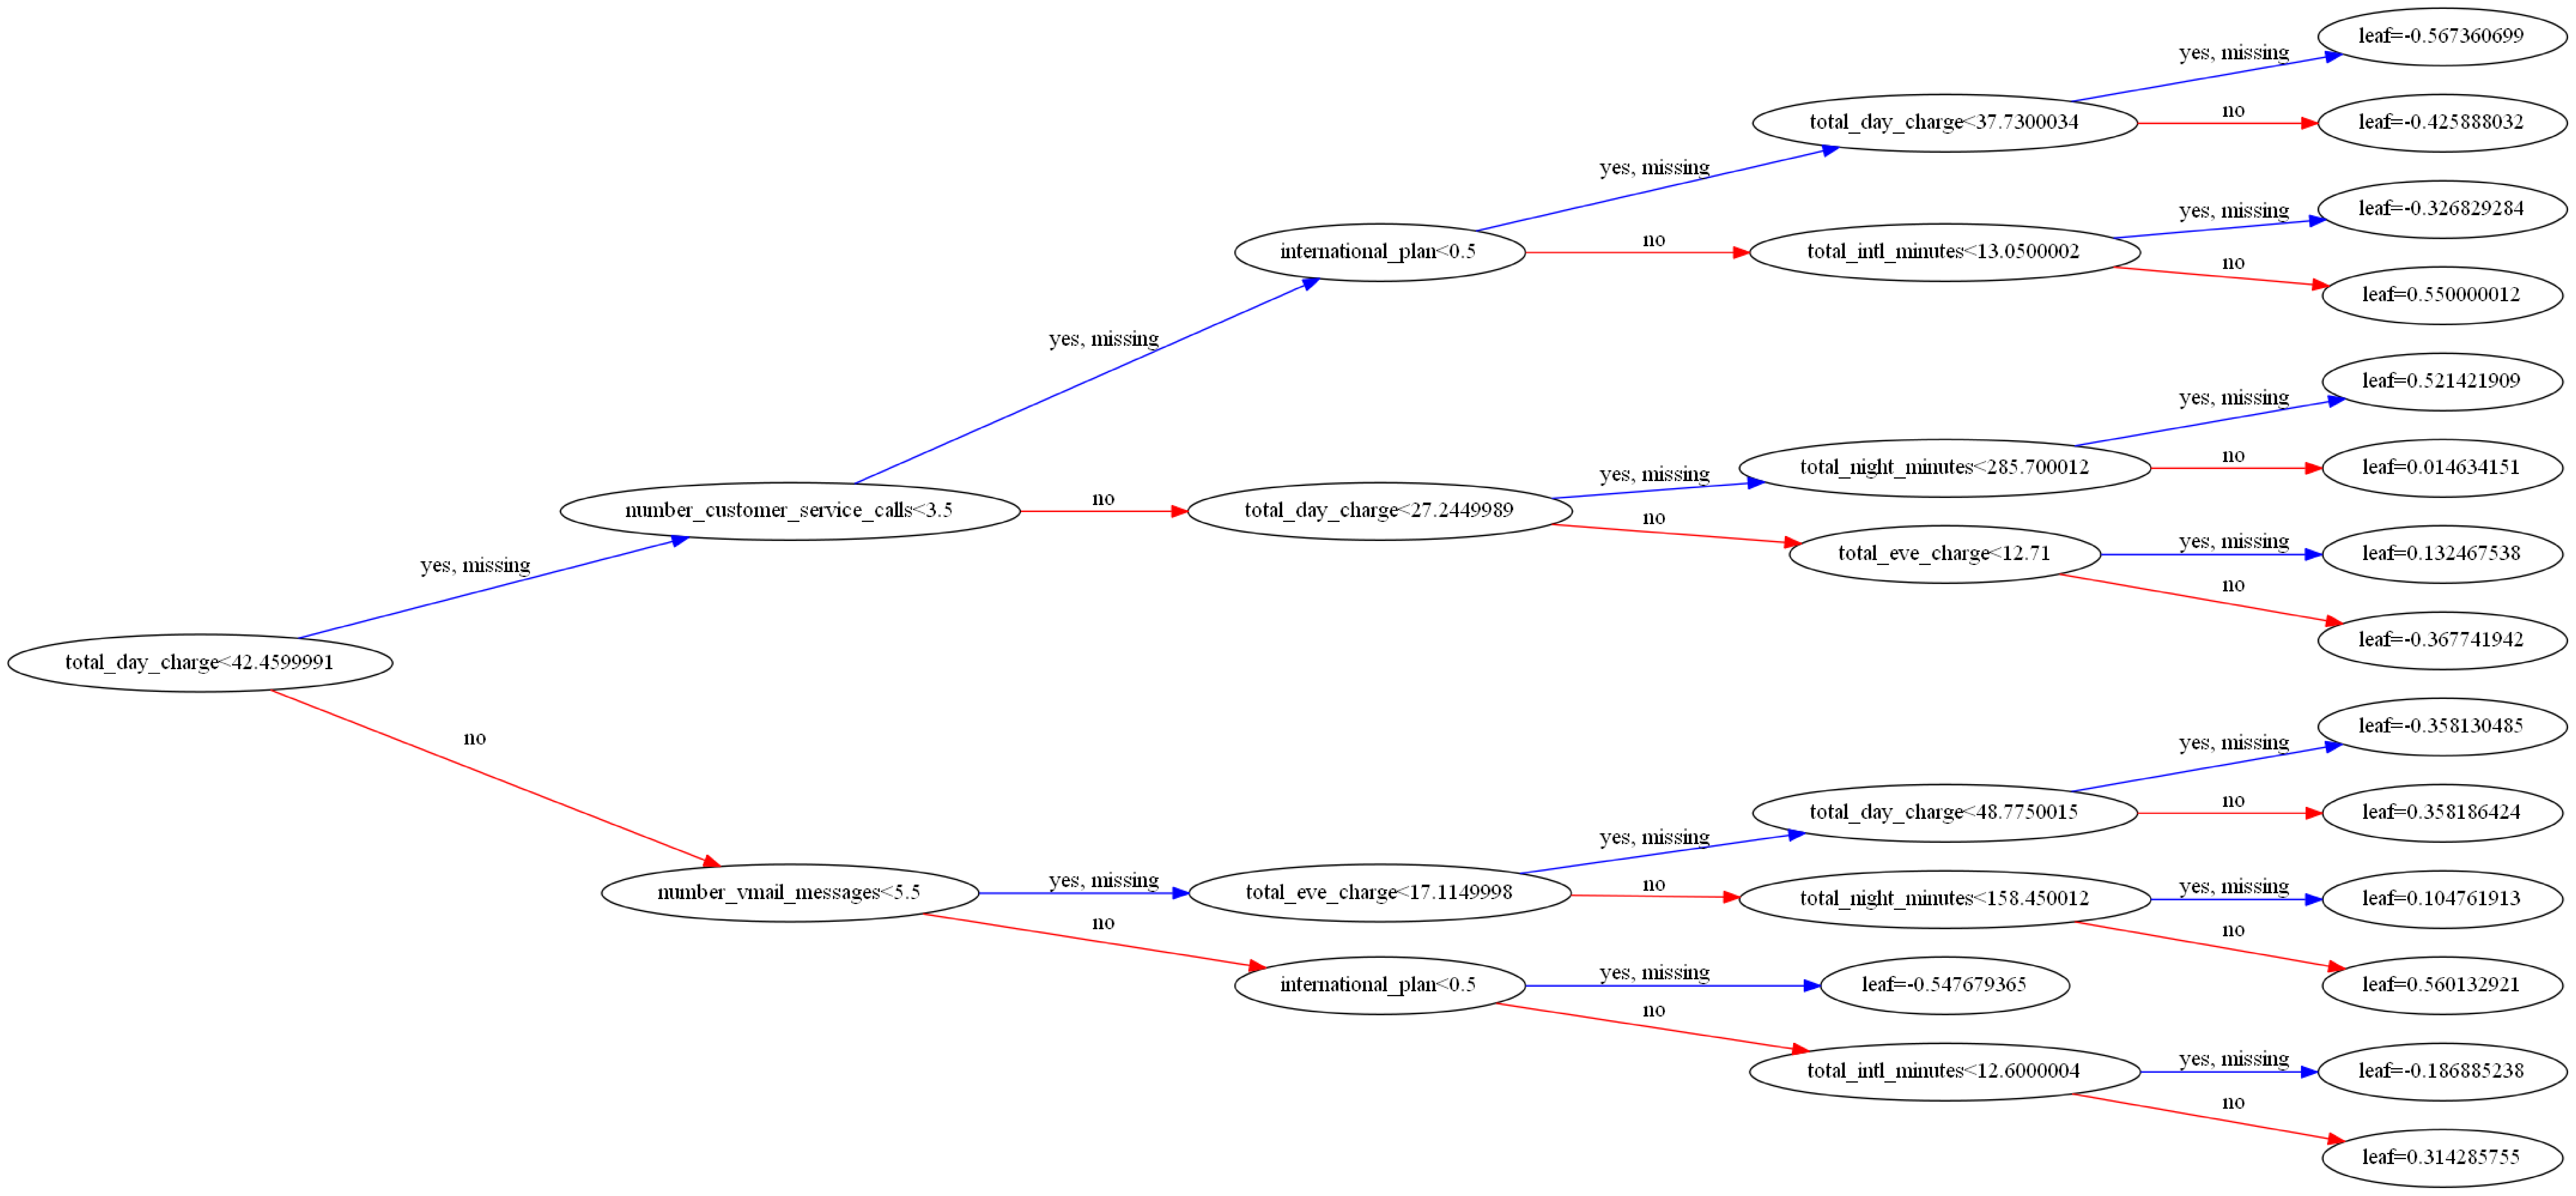

In [41]:
# plot decision tree
import graphviz
from numpy import loadtxt
from xgboost import plot_tree

# plot single tree
xgb.plot_tree(xgboost, num_trees=0, rankdir='LR')
fig = plt.gcf()
fig.set_size_inches(150, 100)

Use Neuron Network for prediction

In [42]:
mlp = MLPClassifier(hidden_layer_sizes=(2,2,2,3,2), activation='identity', solver='lbfgs', random_state=42)
mlp.fit(Xtrain, Ytrain)
Y_pred_mlp = mlp.predict(tests)

submit_mlp = pd.DataFrame({'id':id, 'churn':Y_pred_mlp})
submit_mlp.churn.replace([0,1],['no','yes'], inplace=True)
submit_mlp.to_csv('churn_submitmlp.csv',index=False)

Use KNN for prediction

In [43]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(Xtrain, Ytrain)
Y_pred_knn = neigh.predict(tests)

submit_knn = pd.DataFrame({'id':id, 'churn':Y_pred_knn})
submit_knn.churn.replace([0,1],['no','yes'], inplace=True)
submit_knn.to_csv('churn_submitknn.csv',index=False)

Timing Calculation

In [44]:
import time
results = []
max_depth = [1, 2, 3, 4,5,6,7,8,9,10]

for n in max_depth:
    start = time.time()
    decision_tree = DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=n)
    decision_tree.fit(Xtrain, Ytrain)
    elapsed = time.time() - start
    print(n,round(elapsed,3))
    results.append(elapsed)
results_df=pd.DataFrame(results)
results_df.mean()

1 0.035
2 0.015
3 0.025
4 0.027
5 0.038
6 0.034
7 0.039
8 0.048
9 0.067
10 0.063


0    0.038996
dtype: float64

In [45]:

results = []
max_depth = [1, 2, 3, 4,5,6,7,8,9,10]
for n in max_depth:
    start = time.time()
    xgboost = xgb.XGBClassifier(eta=0.3,max_depth=n)
    xgboost.fit(Xtrain, Ytrain)
    elapsed = time.time() - start
    print(n,round(elapsed,3))
    results.append(elapsed)
results_df=pd.DataFrame(results)
results_df.mean()

[12:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1 0.406
[12:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2 0.443
[12:22:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3 0.633
[12:22:39] WARNING: C:/Users/Administrator/wor

0    0.849728
dtype: float64

In [46]:
results = []
hls = [(5),(5,5),(5,5,5),(5,5,5,5),(5,5,5,5,5),(2),(2,2),(2,2,2),(2,2,2,2),(2,2,2,2,2)]

for n in hls:
    start = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=n, activation='identity', solver='lbfgs', random_state=42)
    mlp.fit(Xtrain, Ytrain)
    elapsed = time.time() - start
    print(n,round(elapsed,3))
    results.append(elapsed)
results_df=pd.DataFrame(results)
results_df.mean()

5 0.116
(5, 5) 0.157
(5, 5, 5) 0.16
(5, 5, 5, 5) 1.107
(5, 5, 5, 5, 5) 1.186
2 0.248
(2, 2) 0.552
(2, 2, 2) 0.807
(2, 2, 2, 2) 0.939
(2, 2, 2, 2, 2) 0.722


0    0.599297
dtype: float64

In [47]:
results = []

for n in range(10):
    start = time.time()
    neigh = KNeighborsClassifier(n_neighbors=i+1)
    neigh.fit(Xtrain, Ytrain)
    elapsed = time.time() - start
    print(n,round(elapsed,3))
    results.append(elapsed)
results_df=pd.DataFrame(results)
results_df.mean()

0 0.008
1 0.007
2 0.007
3 0.008
4 0.005
5 0.003
6 0.004
7 0.005
8 0.005
9 0.005


0    0.005685
dtype: float64

Confusuion Matrix

In [48]:
from dmba import classificationSummary
classificationSummary(Ytest, decision_tree.predict(Xtest))

Confusion Matrix (Accuracy 0.9259)

       Prediction
Actual   0   1
     0 698  26
     1  37  89


In [49]:
classificationSummary(Ytest, xgb_model.predict(Xtest))

Confusion Matrix (Accuracy 0.9482)

       Prediction
Actual   0   1
     0 713  11
     1  33  93


In [50]:
classificationSummary(Ytest, mlp.predict(Xtest))

Confusion Matrix (Accuracy 0.8529)

       Prediction
Actual   0   1
     0 724   0
     1 125   1


In [51]:
classificationSummary(Ytest, neigh.predict(Xtest))

Confusion Matrix (Accuracy 0.8788)

       Prediction
Actual   0   1
     0 720   4
     1  99  27
